In [1]:
import os
import matplotlib.pyplot as plt
import h5py
import phase_contrast as pc
from pathlib import Path
import numpy as np
from PIL import Image
from file_paths import get_path

In [4]:
from scipy.interpolate import interp1d
from helper import crop

from scipy.ndimage import zoom
from scipy.ndimage.morphology import binary_closing, binary_fill_holes, binary_dilation, distance_transform_edt
from skimage.morphology import disk, label
from skimage import measure
import scipy.ndimage as ndimage
from skimage.segmentation import flood_fill

In [7]:
from skimage.filters import threshold_otsu

In [ ]:
from skimage.morphology import extrema
import closed_pores_evaluation as cpe
from skimage import filters

In [5]:
from skimage import exposure
from scipy.ndimage import label

In [8]:
SCRIPT_PATH = os.getcwd()
PHANTOM_DB_FOLDER_NAME = 'database'
TXT_FOULDER_NAME = 'txt_files'
FILE_ID = '123495'
TXT_FILE_NAME = f'diamond {FILE_ID}.txt'

In [9]:
def get_img(file_name):
    file_path = os.path.join(SCRIPT_PATH, PHANTOM_DB_FOLDER_NAME, file_name)

    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf.get(name = file_name)
        dataset = dataset[()]
    return dataset

In [10]:
def binary_fill_boarders(img, value=0, width=5, orientation='v'):
    if orientation =='v':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[:, width:-width] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[:, width:-width] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")
    elif orientation =='h':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[width:-width, :] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[width:-width, :] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")

In [11]:
def get_2d_slice(num, file_id=FILE_ID):
    data_folder = get_path(file_id)

    file_names = Path(data_folder).glob('*.tiff')
    file_names = list(file_names)
    img2d_gray = np.array(Image.open(file_names[num]))

    return img2d_gray

In [12]:
def write_dict_to_file(dict):
    for key, value in dict.items():
        write_item_to_file(key, value)


def write_item_to_file(key, value):
    db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME)
    if not os.path.isdir(db_folder):
        os.mkdir(db_folder)

    file_path = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, TXT_FILE_NAME)
    file_txt = open(file_path,"a")
    file_txt.write(f"{key} {value} \n")
    file_txt.close()


In [13]:
k_dictionary ={}

In [ ]:
a = np.asarray([-3, -4, -1, 2, 3, 2, 1, 5, -5, 1])
np.argmax(np.abs(np.diff(a > 0)))

In [ ]:
def binary_fill_boarders(img, value=0, width=5, orientation='v'):
    if orientation =='v':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[:, width:-width] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[:, width:-width] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")
    elif orientation =='h':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[width:-width, :] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[width:-width, :] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")

In [ ]:
#k_possible_values = [1/10, 1/20, 1/80, 1/100, 1/130, 1/500, 1/300]
k_possible_values = [1/2000, 1/500, 1/300, 1/130, 1/10, 1/2, 3, 5, 10, 1000]
slice_num = 874
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num, '123495')
fig, axes = plt.subplots(3, 4, figsize=(25,15))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

squares = []
for i, k in enumerate(k_possible_values):
    bin_img = pc.binarize_slice(img2d_gray, k=k, mu=25e-8)
    square = np.sum(bin_img)
    squares.append(square)
    axes[i+1].imshow(bin_img, cmap='gray')
    axes[i+1].set_title(f"k={k:.3f}, id={i}, s = {square}")
    axes[i+1].axis("off")

x_log = np.log(k_possible_values)

f2 = interp1d(x_log, squares, kind='quadratic')
axes[-1].plot(x_log, squares, '-o', label='original')
x_new = np.linspace(np.min(x_log), np.max(x_log), num=100, endpoint=True)
y_new = f2(x_new)
axes[-1].plot(x_new, y_new, '-', label='interpolated')
y_horizental_line = np.percentile(y_new, 55)

indx = np.argmax(np.abs(np.diff((y_new - y_horizental_line) > 0)))
x_intersection_point = x_new[indx]
k_calculated = np.exp(x_intersection_point)
axes[-1].axhline(y_horizental_line)
axes[-1].plot([x_intersection_point], [y_horizental_line], marker='o', markersize=10, color="red", label=f'k={k_calculated:.3f}')
x_ticks = ['1/2000', '1/500', '1/300', '1/130', '1/10', '1/2','3', '5', '10', '1000']
plt.xticks(np.log(k_possible_values), x_ticks)
axes[-1].grid()
axes[-1].legend()

plt.tight_layout()

In [ ]:

fig, axes = plt.subplots(figsize=(7, 7))
axes.imshow(pc.binarize_slice(img2d_gray, k=k_calculated, mu=25e-8), cmap='gray')


In [ ]:
#id = 7
#k_dictionary.update({f"{slice_num}": k_possible_values[id]})

k_dictionary.update({f"{slice_num}": k_calculated})

In [ ]:
k_dictionary

In [ ]:
k_dictionary = sorted(k_dictionary.items(), key=lambda item: item[0])
k_dictionary = dict(k_dictionary)

In [ ]:
#k_dictionary = {'750': 500, '780': 0.5, '810': 20, '840': 20, '870': 15}
k_dictionary

In [ ]:
# backup
write_dict_to_file(k_dictionary)
k_dictionary = {}

# _RESULTS_

In [ ]:
file_id='123497'
img3d = get_img(f'{file_id}.h5')

In [ ]:
# 787 = good example
num = np.random.randint(0,2120)

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(img3d[num], cmap='gray')
axes[1].imshow(get_2d_slice(num, file_id), cmap='gray')

# for ax in axes:
#     ax.axis("off")
plt.tight_layout()
num

In [ ]:
img2d=img3d[num]

In [ ]:
def get_2d_mask_by_crop(img2d, margin):
    mask = np.ones(img2d.shape)
    return binary_fill_boarders(mask, value=0, width=margin, orientation='h')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

axes[0].imshow(img2d, cmap='gray')

margin = 100
axes[0].axhline(margin, color="red", lw=5)
axes[0].axhline(img2d.shape[0]-margin, color="red", lw=5)
axes[1].imshow(get_2d_slice(num, file_id), cmap='gray')

axes[2].imshow(img2d*2+get_2d_mask_by_crop(img2d, margin=100), cmap='gray')
# for ax in axes:
#     ax.axis("off")
plt.tight_layout()

# PORE SIZES SOBEL

In [ ]:
file_id='123497'
# img3d = get_img(f'{file_id}.h5')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
num = 500 # 320
img2d_grey = get_2d_slice(num, file_id=file_id) # img3d[num]
ax.imshow(img2d_grey, cmap="gray")
ax.axis("off")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
edge_sobel = filters.sobel(img2d_grey)

coefs = np.linspace(1,4, 20)
thresh = filters.threshold_otsu(edge_sobel)

edge_total_volumes = []
for coef in coefs:
    img2d = edge_sobel > thresh * coef
    edge_total_volumes.append(np.sum(img2d))

ax.plot(coefs, edge_total_volumes)
ax.set_xlabel("coefs")
ax.set_ylabel("volumes")
# ax.imshow(img2d, cmap="gray")
# ax.axis("off")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
edge_sobel = filters.sobel(img2d_grey)

thresh = filters.threshold_otsu(edge_sobel) * 1.7
img2d = binary_fill_holes(edge_sobel > thresh)
ax.imshow(img2d, cmap="gray")

In [ ]:
img2d_edges = cpe.filter_pores_mask(img2d,
                                    lowest_value=3,
                                    highest_value = 225)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img2d_edges, cmap="gray")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
img2d_grey = get_2d_slice(num, file_id=file_id)
ax.imshow(img2d_grey, cmap=plt.cm.gray)
mask = np.ma.masked_where(img2d_edges < 1, img2d_edges)
ax.imshow(mask, cmap='hsv', interpolation='none')
ax.axis()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
window_size = 300
img2d_grey = get_2d_slice(num, file_id=file_id)
img_2d_gray_frag = crop(img2d_grey, (window_size, window_size), (1500, 2000))
ax.imshow(img_2d_gray_frag, cmap=plt.cm.gray)

img2d_edges_frag = crop(img2d_edges, (window_size, window_size), (1500, 2000))
mask = np.ma.masked_where(img2d_edges_frag < 1, img2d_edges_frag)
ax.imshow(mask, cmap='hsv', alpha=0.3, interpolation='none')
ax.axis("off")

In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="volume",
                             num_of_bins=100,
                             max_x_value=None,
                             min_x_value=5,
                             log_scale=False,
                             save_plot=False)

In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="diameter",
                             num_of_bins=100,
                             max_x_value=None,
                             min_x_value=5,
                             log_scale=False,
                             save_plot=False)

# PORE SIZES Percentile

In [ ]:
file_id='123497'
fig, ax = plt.subplots(figsize=(10, 10))
num = 500 # 320
img2d_grey = get_2d_slice(num, file_id=file_id) # img3d[num]
ax.imshow(img2d_grey, cmap="gray")
ax.axis("off")

In [ ]:
percentiles = [1, 2, 5, 8] # np.arange(2,10)
fig, axes = plt.subplots(ncols=len(percentiles)+1, figsize=(10*len(percentiles)+3, 10))
axes = axes.ravel()
# thresh_low = np.percentile(img2d_grey.ravel(), low_percentile)

edge_total_volumes = []
for ax, percentile in zip(axes, percentiles):
    img2d = img2d_grey < np.percentile(img2d_grey.ravel(), percentile)
    ax.imshow(img2d, cmap="gray")
    ax.axis("off")
    ax.set_title(f"percentile {percentile}")
    edge_total_volumes.append(np.sum(img2d))

axes[-1].plot(percentiles, edge_total_volumes, '-o')
axes[-1].set_xlabel("percentiles")
axes[-1].set_ylabel("volumes")
axes[-1].grid()

plt.tight_layout()
# ax.imshow(img2d, cmap="gray")
# ax.axis("off")

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 15))
percentile = 1
thresh_low = np.percentile(img2d_grey.ravel(), percentile)

img2d = img2d_grey < thresh_low
axes[0].imshow(img2d_grey, cmap="gray")
axes[1].imshow(img2d, cmap="gray")
axes[1].set_title(f"lower than percentile {percentile}")

axes[2].imshow(binary_fill_holes(img2d), cmap="gray")
axes[2].set_title("holes filled")

In [ ]:
max_pore_volume = 225
min_pore_volume = 3
img2d_edges = cpe.filter_pores_mask(img2d,
                                    lowest_value = min_pore_volume,
                                    highest_value = max_pore_volume)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img2d_edges, cmap="gray")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
img2d_grey = get_2d_slice(num, file_id=file_id)
ax.imshow(img2d_grey, cmap=plt.cm.gray)
mask = np.ma.masked_where(img2d_edges < 1, img2d_edges)
ax.imshow(mask, cmap='hsv', interpolation='none')
ax.axis()

In [ ]:
plots=4
fig, axes = plt.subplots(ncols=2, nrows=plots, figsize=(14, 7*plots), constrained_layout=True)
fig.suptitle(f'Comparison of random squares. Pore volume: max={max_pore_volume}; min={min_pore_volume}', fontsize=16)
axes= axes.ravel()
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
window_size = 400

for i, ax in enumerate(axes):
    if i % 2 == 0:
        center_coords = np.asarray([np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1),
                                    np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1)])
                                    
        img_2d_gray_frag = crop(img2d_grey, (window_size, window_size), center_coords)
        ax.imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        axes[i+1].imshow(img_2d_gray_frag, cmap=plt.cm.gray)

        img2d_edges_frag = crop(img2d_edges, (window_size, window_size), center_coords)
        mask = np.ma.masked_where(img2d_edges_frag < 1, img2d_edges_frag)
        ax.imshow(mask, cmap='hsv', alpha=0.3, interpolation='none')
    ax.axis("off")


In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="volume",
                             num_of_bins=100,
                             max_x_value=None,
                             min_x_value=5,
                             log_scale=False,
                             save_plot=False)

In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="diameter",
                             num_of_bins=100,
                             max_x_value=None,
                             min_x_value=5,
                             log_scale=False,
                             save_plot=False)

# Percetile advanced: without boarders 

(-0.5, 2519.5, 2519.5, -0.5)

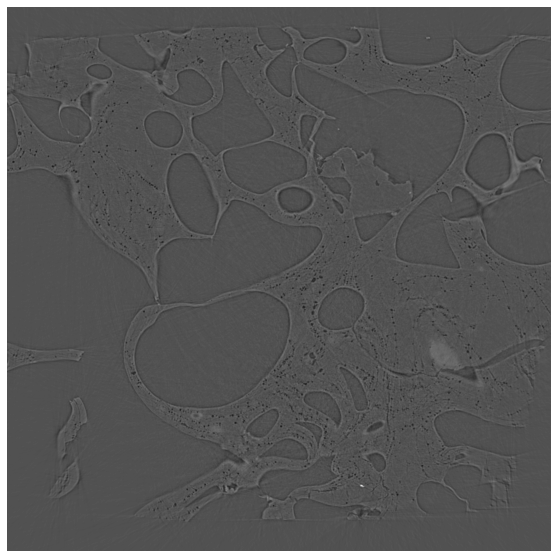

In [14]:
file_id='123497'
fig, ax = plt.subplots(figsize=(10, 10))
num = 500 # 320
img2d_grey = get_2d_slice(num, file_id=file_id) # img3d[num]
ax.imshow(img2d_grey, cmap="gray")
ax.axis("off")

Text(0.5, 1.0, 'equalized')

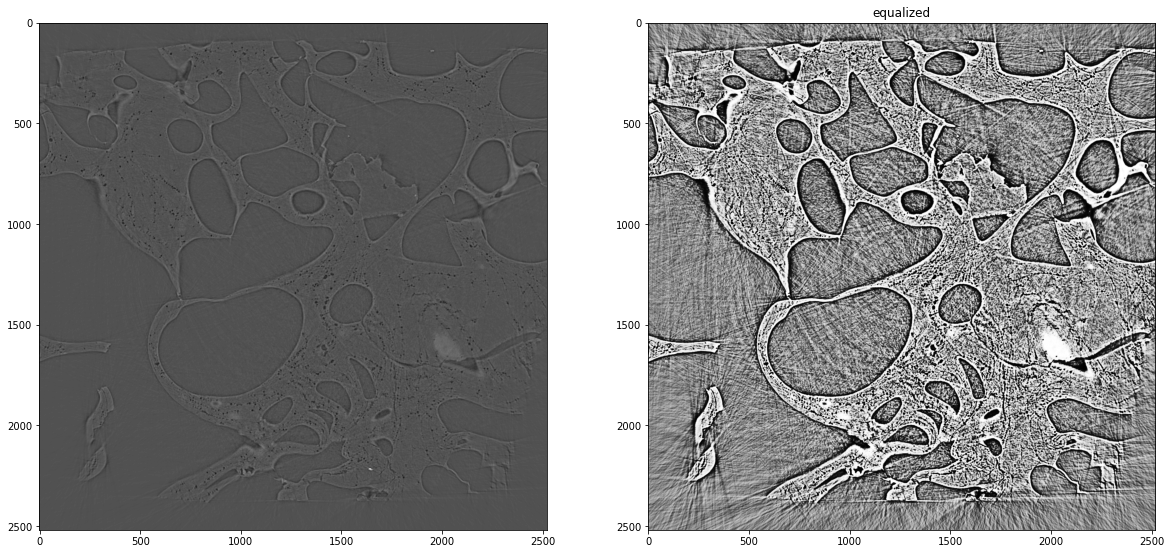

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
percentile = 1
thresh_low = np.percentile(img2d_grey.ravel(), percentile)

img2d = img2d_grey < thresh_low
axes[0].imshow(img2d_grey, cmap="gray")

img_equalized = exposure.equalize_hist(img2d_grey)
axes[1].imshow(img_equalized, cmap="gray")
axes[1].set_title(f"equalized")

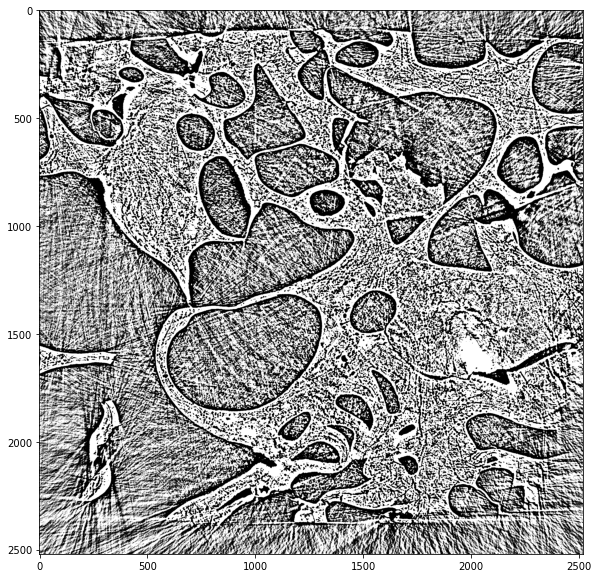

In [16]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))

img_equalized_binarized = img_equalized>0.5
ax.imshow(img_equalized_binarized, cmap="gray")

In [18]:
mask = cpe.find_mask_longest_contours(~img_equalized_binarized,
                                      filter_by_contour_length=True,
                                      max_number_of_contours=None,
                                      min_contour_length=3000)

number of selected contour:  69


Text(0.5, 1.0, 'contours were here')

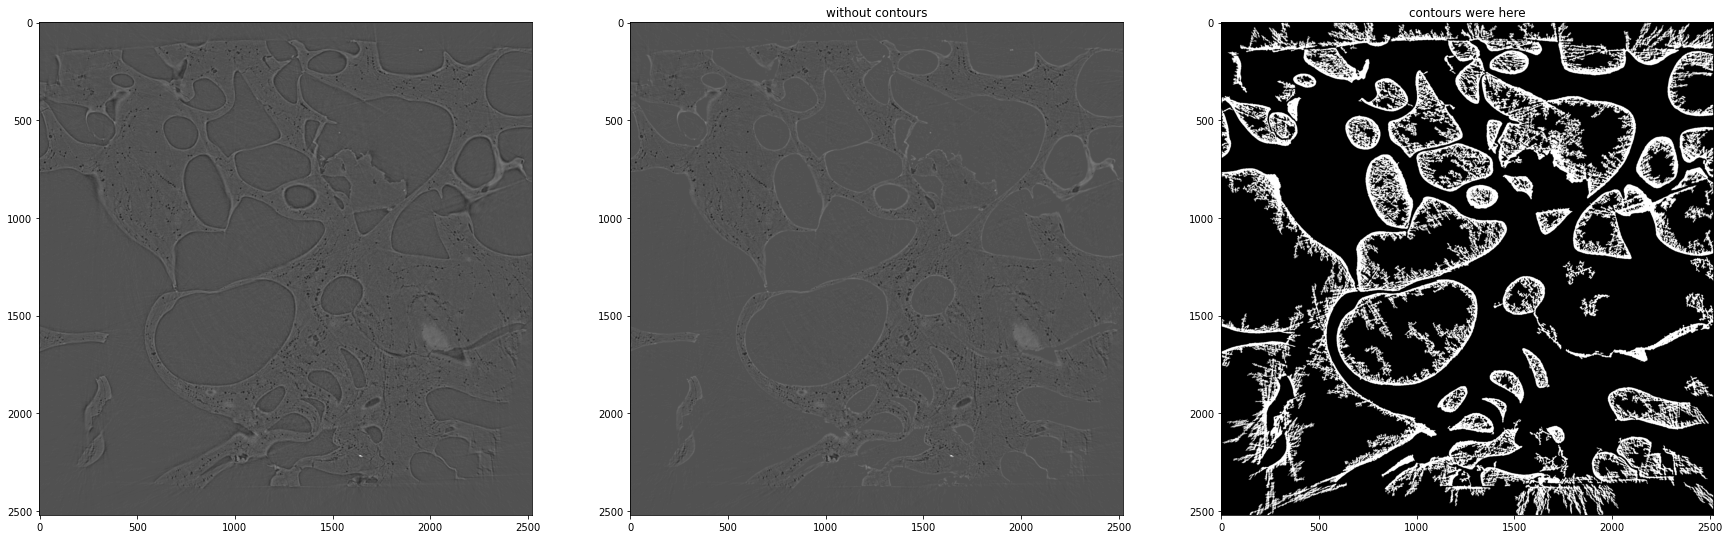

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))

axes[0].imshow(img2d_grey, cmap="gray")

img_equalized = exposure.equalize_hist(img2d_grey)

img_without_big_contours = cpe.hide_contours_in_image(img2d_grey, mask)
axes[1].imshow(img_without_big_contours, cmap="gray")
axes[1].set_title(f"without contours")

axes[2].imshow(mask, cmap="gray")
axes[2].set_title(f"contours were here")

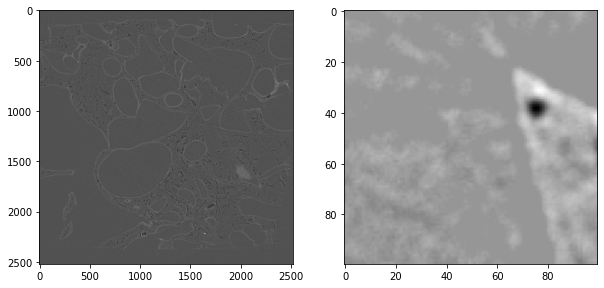

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 20))

axes[0].imshow(img_without_big_contours, cmap="gray")

center = (1000, 2000)
shape=(100, 100)
cropped_fragment = crop(img_without_big_contours, shape, center)
axes[1].imshow(cropped_fragment, cmap="gray")

In [26]:
from scipy.signal import fftconvolve

def filter_mean(img, kernel_size = 3):
    kernel_shape = np.ones(img.ndim, dtype=int) * kernel_size
    kernel = np.ones(kernel_shape, dtype=int)
    # kernel = kernel / np.sum(kernel)
    return fftconvolve(img, kernel, mode='same')

In [22]:
from skimage.filters import median
from skimage.morphology import disk

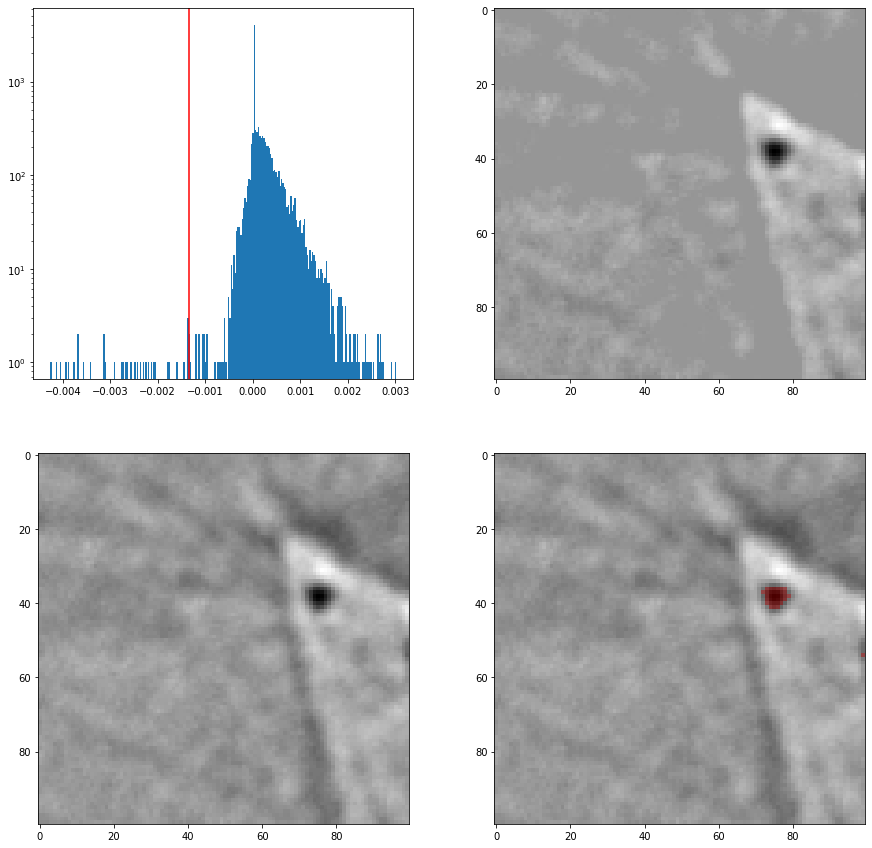

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
axes = axes.flatten()

filtered_cropped_fragment = cropped_fragment #median(cropped_fragment, disk(3))
_ = axes[0].hist(filtered_cropped_fragment.flatten(), bins=255, log=True)

global_thresh = np.min(filtered_cropped_fragment) + (np.max(filtered_cropped_fragment) - np.min(filtered_cropped_fragment))*0.4
 #threshold_otsu(filtered_cropped_fragment)
axes[0].axvline(x=global_thresh, color='red')
axes[1].imshow(filtered_cropped_fragment, cmap="gray")

bin_cropped_fragment = filtered_cropped_fragment>global_thresh
axes[2].imshow(crop(img2d_grey, shape, center), cmap="gray")
mask_cropped_fragment = np.ma.masked_where(bin_cropped_fragment, bin_cropped_fragment)

axes[3].imshow(crop(img2d_grey, shape, center), cmap="gray")
axes[3].imshow(mask_cropped_fragment, cmap='hsv', alpha=0.3, interpolation='none')

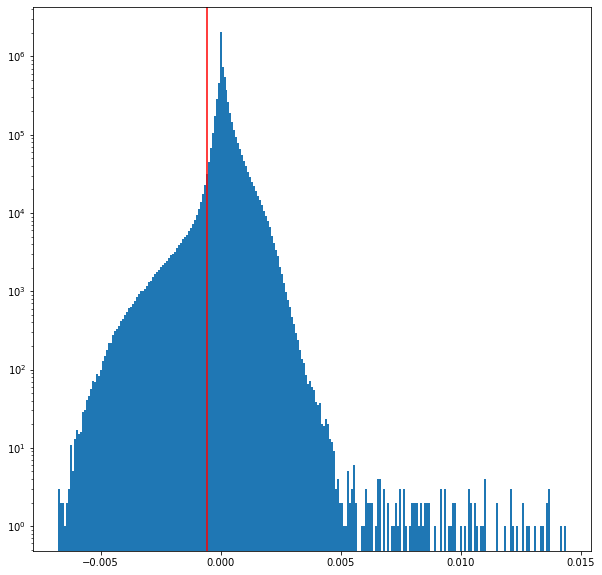

In [43]:
fig, axes = plt.subplots(figsize=(10, 10))

_ = axes.hist(img_without_big_contours.flatten(), bins=255, log=True)
axes.axvline(x=global_thresh, color='red')

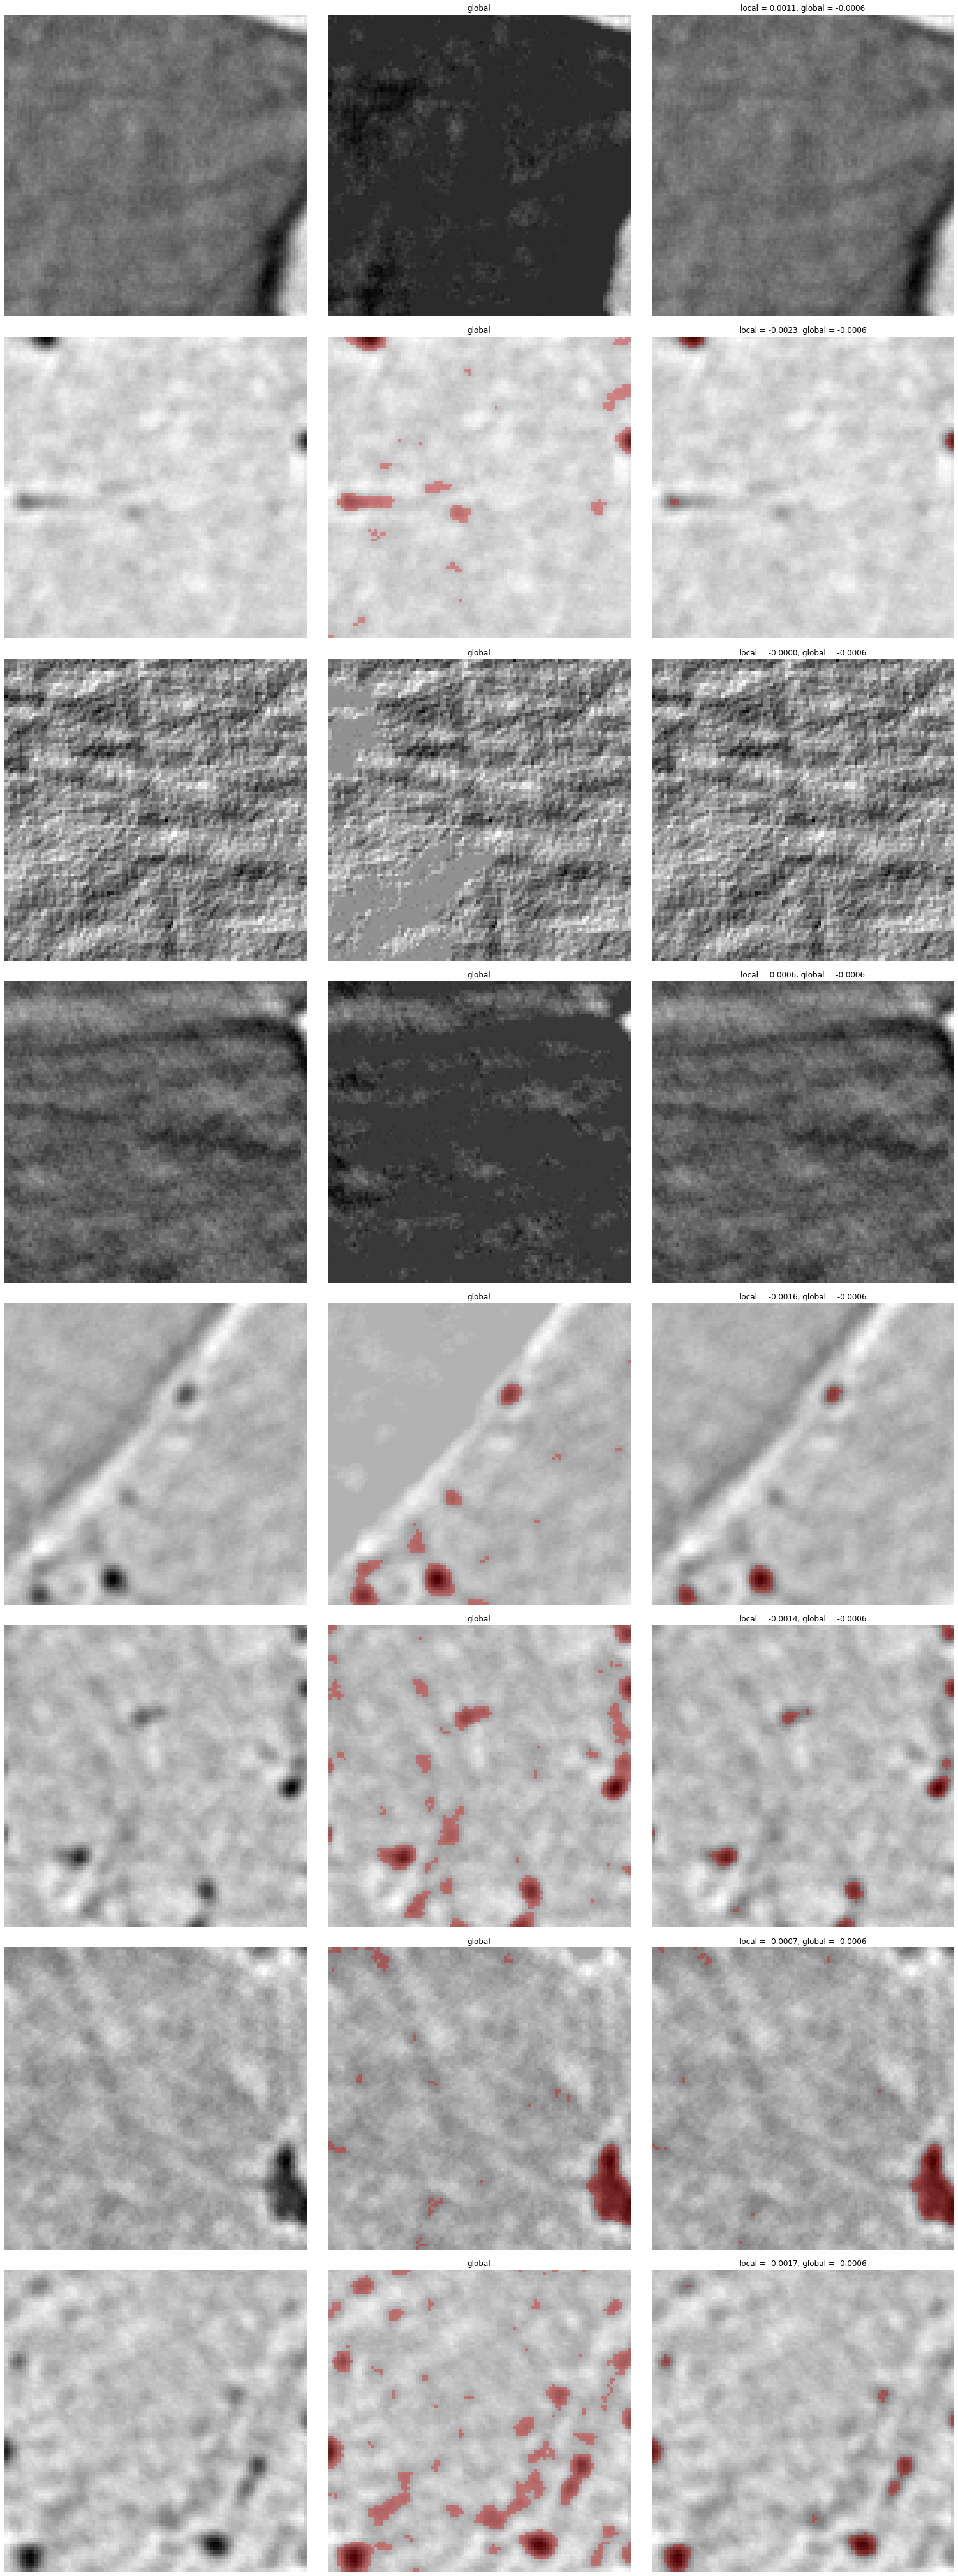

In [41]:
plots=8
fig, axes = plt.subplots(ncols=3, nrows=plots, figsize=(21, 7*plots), constrained_layout=True)
axes= axes.ravel()
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
window_size = 100
percentile = 3
global_thresh = np.percentile(img_without_big_contours.ravel(), percentile)

for i, ax in enumerate(axes):
    if i % 3 == 0:
        center_coords = np.asarray([np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1),
                                    np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1)])              
        img_2d_gray_frag = crop(img2d_grey, (window_size, window_size), center_coords)
        ax.imshow(img_2d_gray_frag, cmap=plt.cm.gray)

        img_without_contours_frag = crop(img_without_big_contours, (window_size, window_size), center_coords)
        axes[i+1].imshow(img_without_contours_frag, cmap=plt.cm.gray)
    
        bin_cropped_fragment_glob = img_without_contours_frag>global_thresh
        mask_cropped_fragment_glob = np.ma.masked_where(bin_cropped_fragment_glob, bin_cropped_fragment_glob)
        axes[i+1].imshow(mask_cropped_fragment_glob, cmap='hsv', alpha=0.3, interpolation='none')
        axes[i+1].set_title(f"global")

        min_brightness = np.min(img_without_contours_frag)
        max_brightness = np.max(img_without_contours_frag)
        local_thresh = min_brightness + (max_brightness - min_brightness)*0.5

        axes[i+2].set_title(f"local = {local_thresh:.4f}, global = {global_thresh:.4f}")
        if local_thresh > global_thresh:
            local_thresh = global_thresh

        bin_cropped_fragment = img_without_contours_frag>local_thresh
        mask_cropped_fragment = np.ma.masked_where(bin_cropped_fragment, bin_cropped_fragment)
        
        axes[i+2].imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        axes[i+2].imshow(mask_cropped_fragment, cmap='hsv', alpha=0.3, interpolation='none')

    ax.axis("off")


In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), constrained_layout=True)
# axes = axes.ravel()
# for ax in axes:
#     ax.axis("off")
# axes[0].imshow(mask, cmap="gray")

# axes[1].imshow(binary_fill_holes(mask), cmap="gray")
# axes[1].set_title(f"contours were here")

# axes[2].imshow(img2d_grey, cmap="gray")

# mask_f = binary_fill_holes(mask)
# axes[3].imshow(img2d_grey, cmap="gray")
# axes[3].imshow(np.ma.masked_where(mask_f < 1, mask_f), cmap='hsv', alpha=0.3, interpolation='none')
# axes[3].set_title('without_boarders')

In [ ]:
percentile_max = 5
fig, axes = plt.subplots(ncols=2, nrows=percentile_max+1, figsize=(20, 10*(percentile_max+1)))

axes[0, 1].imshow(img_without_big_contours, cmap="gray")
axes[0, 1].set_title(f"large contours removed")

axes[0, 0].imshow(img2d_grey, cmap="gray")
axes[0, 1].set_title(f"original")

for i, percentile in enumerate(range(percentile_max)):
    thresh_low_filtered = np.percentile(img_without_big_contours.ravel(), percentile+1)
    axes[i+1, 0].imshow(binary_fill_holes(img_without_big_contours < thresh_low_filtered), cmap="gray")
    axes[i+1, 0].set_title(f"percentile = {percentile+1}")

    thresh_low_orig = np.percentile(img2d_grey.ravel(), percentile+1)
    axes[i+1, 1].imshow(binary_fill_holes(img2d_grey < thresh_low_orig), cmap="gray")
    axes[i+1, 1].set_title(f"percentile = {percentile+1}")

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
for ax in axes:
    ax.imshow(img2d_grey, cmap=plt.cm.gray)

percentile = 2.5

thresh = np.percentile(img2d_grey.ravel(), percentile)
img_small_pores_with_boarders = binary_fill_holes(img2d_grey < thresh)
mask_img_small_pores = np.ma.masked_where(img_small_pores_with_boarders < 1, img_small_pores_with_boarders)
axes[1].imshow(mask_img_small_pores, cmap='hsv', interpolation='none')
axes[1].set_title('original')

thresh = np.percentile(img_without_big_contours.ravel(), percentile)
img_small_pores = binary_fill_holes(img_without_big_contours < thresh)
mask_img_small_pores = np.ma.masked_where(img_small_pores < 1, img_small_pores)
axes[0].imshow(mask_img_small_pores, cmap='hsv', interpolation='none')
axes[0].set_title('without_boarders')

In [ ]:
plots=8
fig, axes = plt.subplots(ncols=3, nrows=plots, figsize=(21, 7*plots), constrained_layout=True)
fig.suptitle(f'Comparison of random squares', fontsize=16)
axes= axes.ravel()
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
window_size = 400

for i, ax in enumerate(axes):
    if i % 3 == 0:
        center_coords = np.asarray([np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1),
                                    np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1)])
                                    
        img_2d_gray_frag = crop(img2d_grey, (window_size, window_size), center_coords)
        ax.imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        ax.set_title('boarders excluded')
        axes[i+1].imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        ax.set_title('with boarders')
        axes[i+2].imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        ax.set_title('original img')

        img_small_pores_frag = crop(img_small_pores, (window_size, window_size), center_coords)
        mask = np.ma.masked_where(img_small_pores_frag < 1, img_small_pores_frag)
        ax.imshow(mask, cmap='hsv', alpha=0.3, interpolation='none')

        img_small_pores_b_frag = crop(img_small_pores_with_boarders, (window_size, window_size), center_coords)
        mask = np.ma.masked_where(img_small_pores_b_frag < 1, img_small_pores_b_frag)
        axes[i+1].imshow(mask, cmap='hsv', alpha=0.3, interpolation='none')
    ax.axis("off")


# Binarization by histogram equalization

In [ ]:
file_id='123493'
fig, ax = plt.subplots(figsize=(10, 10))
num = 500 # 320
img2d_grey = get_2d_slice(num, file_id=file_id) # img3d[num]
ax.imshow(img2d_grey, cmap="gray")
ax.axis("off")

In [ ]:
img_equalized = exposure.equalize_hist(img2d_grey)

In [ ]:
img_equalized_binarized = img_equalized>0.5

mask = cpe.find_mask_longest_contours(~img_equalized_binarized,
                                      filter_by_contour_length=True,
                                      min_contour_length = 2500,
                                      max_number_of_contours=None
                                      )

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), constrained_layout=True)
axes = axes.ravel()
for ax in axes:
    ax.axis("off")
axes[0].imshow(mask, cmap="gray")

axes[1].imshow(binary_fill_holes(mask), cmap="gray")
axes[1].set_title(f"contours were here")

axes[2].imshow(img2d_grey, cmap="gray")

mask_f = binary_fill_holes(mask)
axes[3].imshow(img2d_grey, cmap="gray")
axes[3].imshow(np.ma.masked_where(mask_f < 1, mask_f), cmap='hsv', alpha=0.3, interpolation='none')
axes[3].set_title('without_boarders')

# Adaptive thresholding

# Report

In [ ]:
file_id='123498'
fig, ax = plt.subplots(figsize=(10, 10))
num = 2000 # 320
img2d_grey = get_2d_slice(num, file_id=file_id) # img3d[num]
ax.imshow(img2d_grey, cmap="gray")
ax.axis("off")

In [ ]:
percentile = 0.5
thresh_low = np.percentile(img2d_grey.ravel(), percentile)

img2d = img2d_grey < thresh_low

max_pore_volume = 225
min_pore_volume = 2
img2d_edges = cpe.filter_pores_mask(img2d,
                                    lowest_value = min_pore_volume,
                                    highest_value = max_pore_volume)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img2d_edges, cmap="gray")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
ax.imshow(img2d_grey, cmap=plt.cm.gray)
mask = np.ma.masked_where(img2d_edges < 1, img2d_edges)
ax.imshow(mask, cmap='hsv', interpolation='none')
ax.axis()

In [ ]:
plots=20
fig, axes = plt.subplots(ncols=2, nrows=plots, figsize=(7, 3.5*plots), constrained_layout=True)
fig.suptitle(f'Comparison of random squares. Pore volume: max={max_pore_volume}; min={min_pore_volume}', fontsize=16)
axes= axes.ravel()
#ax.imshow(3*img2d+img3d_pseudo_lsv[1], cmap=plt.cm.nipy_spectral)
window_size = 400

for i, ax in enumerate(axes):
    if i % 2 == 0:
        center_coords = np.asarray([np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1),
                                    np.random.randint(window_size//2+1, img2d_grey.shape[0]-window_size//2-1)])
                                    
        img_2d_gray_frag = crop(img2d_grey, (window_size, window_size), center_coords)
        ax.imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        axes[i+1].imshow(img_2d_gray_frag, cmap=plt.cm.gray)
        img2d_edges_frag = crop(img2d_edges, (window_size, window_size), center_coords)
        mask = np.ma.masked_where(img2d_edges_frag < 1, img2d_edges_frag)
        ax.imshow(mask, cmap='hsv', interpolation='none')
    ax.axis("off")
    

In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="diameter",
                             num_of_bins=50,
                             max_x_value=None,
                             min_x_value=2,
                             pixel_size_mkm=0.8125,
                             add_median=True,
                             add_mean=True,
                             log_scale=False,
                             save_plot=False)

In [ ]:
cpe.plot_pore_size_histogram(img2d_edges,
                             structure_neighbors_num=6,
                             size_type="volume",
                             num_of_bins=100,
                             max_x_value=None,
                             min_x_value=None,
                             pixel_size_mkm=0.8125,
                             add_median=True,
                             add_mean=True,
                             log_scale=False,
                             save_plot=False)

# STATISTICS

In [ ]:
def get_img2d_pores(img2d_grey,
                    percentile = 0.5,
                    min_pore_volume = 2,
                    max_pore_volume = 225):
    thresh_low = np.percentile(img2d_grey.ravel(), percentile)
    img2d_bin = img2d_grey < thresh_low
    img2d_pores = cpe.filter_pores_mask(img2d_bin,
                                        lowest_value = min_pore_volume,
                                        highest_value = max_pore_volume)
    return img2d_pores
    

In [ ]:
def calc_histogram(img2d_pores, pixel_size_mkm, num_of_bins, min_x_value=2, max_x_value=None):
    pixel_size_mkm=0.8125
    pore_volume_distribution = cpe.get_pore_volume_distribution(img2d_pores, 6) * pixel_size_mkm
    if not max_x_value:
        max_x_value = np.max(pore_volume_distribution)
    bins = np.linspace(min_x_value-1, max_x_value, num_of_bins+1)
    return np.histogram(pore_volume_distribution, bins=bins)

In [ ]:
def plot_error_hist(hist, bins, stats=None, fontsize=25):
    """
    stats = dict(unit_name="", size_type="", min_x_value, max_x_value)
    """
    fig, ax = plt.subplots(figsize=(10,10))
    #plt.rcParams.update({'font.size': fontsize})
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    ax.bar(center,
           hist, 
           align='center',
           width=width,
           edgecolor ='k',
           yerr=10,
           ecolor='r',
           error_kw=dict(capsize=3))
    ax.set_ylabel("count")

    if stats:
        stats = (f'MAX pore {stats["size_type"]} = {stats["max_x_value"]:.2f} {stats["unit_name"]}\n'
                 f'MIN pore {stats["size_type"]} = {stats["min_x_value"]:.2f} {stats["unit_name"]}\n')
        #ax.set_xlabel(stats["unit_name"])
        bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.35)
        ax.text(0.95,
                0.5,
                stats,
                fontsize=fontsize,
                bbox=bbox,
                transform=ax.transAxes, horizontalalignment='right')
    ax.grid()

    # return fig

In [ ]:
img2d_pores = get_img2d_pores(img2d_grey,
                              percentile = 0.5,
                              min_pore_volume = 2,
                              max_pore_volume = 225)


In [ ]:
hist, bins = calc_histogram(img2d_pores, 0.8125, num_of_bins=50)

In [ ]:
stats = dict(unit_name="mkm", size_type="volumes", min_x_value=2, max_x_value=225)

plot_error_hist(hist, bins, stats)

In [ ]:
plot_error_hist(hist, bins, stats)